<a href="https://colab.research.google.com/github/gormantt/foursquare-location-matching/blob/main/Ling_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis

---
Data analyzed in this notebook is from [Kaggle's code competation: Foursquare - Location Matching](https://www.kaggle.com/competitions/foursquare-location-matching/data). The data comprises over one-and-a-half million place entries for hundreds of thousands of commercial Points-of-Interest (POIs) around the globe. The task is to **determine which place entries describe the same point-of-interest**. Though the data entries may represent or resemble entries for real places, they may also contain artificial information or additional noise.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

#For plotting
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

We read the data below and take a look at some columns.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pairs = pd.read_csv('/content/drive/MyDrive/Summer 2022/foursquare-location-matching/pairs.csv')
test = pd.read_csv('/content/drive/MyDrive/Summer 2022/foursquare-location-matching/test.csv')
train = pd.read_csv('/content/drive/MyDrive/Summer 2022/foursquare-location-matching/train.csv')

# Training data

---

## The data


*   `train.csv` - The training set, comprising eleven attribute fields for over one million place entries, together with:
  * `id` - A unique identifier for each entry.
  * `point_of_interest` - An identifier for the POI the entry represents. There may be one or many entries describing the same POI. Two entries "match" when they describe a common POI. 
*   `pairs.csv` - A pregenerated set of pairs of place entries from `train.csv` designed to improve detection of matches.
  * `match` - Whether (`True` or `False`) the pair of entries describes a common POI.



In [ ]:
print('There are', len(set(train.id)), 'id, and', len(set(train.point_of_interest)), 'distinct POIs.\n')
print('About', np.round(len(set(train.point_of_interest))/len(set(train.id))*100,2),'% POIs are unique.\n')

There are 1138812 id, and 739972 distinct POIs.

About 64.98 % POIs are unique.



In [ ]:
train.sample(5)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
173577,E_26ef84eb715951,北海道エネルギー米里,43.072128,141.408112,NaN,NaN,NaN,NaN,JP,NaN,NaN,Gas Stations,P_d5116b1dfd2c4a
598596,E_86894993083b72,Kaya Çay Ocaği,38.155328,27.357737,NaN,NaN,NaN,NaN,TR,NaN,NaN,Tea Rooms,P_80741d334aed3d
1045660,E_eaf5d745d65505,Arepa & Pizza,6.209766,-75.567632,NaN,NaN,NaN,NaN,CO,NaN,NaN,Arepa Restaurants,P_4f61823f4492f8
82833,E_12889abf8b06ec,WYANDOTTE AT 11TH,39.100807,-94.585485,NaN,Kansas City,MO,NaN,US,NaN,NaN,Bus Stops,P_1889d5af129f2f
603118,E_878b59392ee860,Üzer Kardeşler Alüminyum,36.759840,27.688953,kizlan sokak,Kızlan Köyü,Muğla,48900,TR,NaN,NaN,Street Fairs,P_6e5067a2301224


In [ ]:
print('There are', len(pairs), 'pairs,', len(set(pairs.id_1)), 'id_1s and', len(set(pairs.id_2)), 'id_2s.\n')

There are 578907 pairs, 464765 id_1s and 565512 id_2s.



In [ ]:
pairs.head()

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,longitude_2,address_2,city_2,state_2,zip_2,country_2,url_2,phone_2,categories_2,match
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,...,3.635206,NaN,NaN,NaN,NaN,BE,NaN,NaN,Bars,True
1,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,...,27.845560,batı aydın,aydın,NaN,67500,TR,NaN,NaN,Electronics Stores,False
2,E_000023d8f4be44,Island Spa,14.518970,121.018702,"5th Flr, Newport Mall, Resorts World Manila",Pasay City,Metro Manila,NaN,PH,NaN,...,121.019827,NaN,NaN,NaN,NaN,PH,NaN,NaN,Spas,True
3,E_00007dcd2bb53f,TOGO'S Sandwiches,38.257797,-122.064599,"1380 Holiday Ln., Ste. B",Fairfield,CA,94534,US,https://locations.togos.com/ll/US/CA/Fairfield...,...,-122.064606,NaN,Fairfield,CA,NaN,US,NaN,NaN,Sandwich Places,True
4,E_0000c362229d93,Coffee Cat,7.082218,125.610244,F. Torres St.,Davao City,Davao Region,8000,PH,NaN,...,125.611457,E. Jacinto Extension,Davao City,Davao Region,8000,PH,NaN,NaN,"Coffee Shops, Cafés, Dessert Shops",False


## Considering only US locations

In [ ]:
train_US = train.loc[train.country=='US']
pairs_US = pairs.loc[(pairs.country_1=='US') & (pairs.country_2=='US')]

In [ ]:
print("{:.2%}".format(len(train_US)/len(train)),'locations are in US')
print("{:.2%}".format(len(pairs_US)/len(pairs)),'pairs are in US')

21.54% locations are in US
20.33% pairs are in US


## Missing values




In [ ]:
for col in train.columns:
    print('In train.csv,',"{:.2%}".format(1-len(train[col].dropna())/len(train[col])), 'rows have "NaN" for', col)

In train.csv, 0.00% rows have "NaN" for id
In train.csv, 0.00% rows have "NaN" for name
In train.csv, 0.00% rows have "NaN" for latitude
In train.csv, 0.00% rows have "NaN" for longitude
In train.csv, 34.83% rows have "NaN" for address
In train.csv, 26.27% rows have "NaN" for city
In train.csv, 36.93% rows have "NaN" for state
In train.csv, 52.28% rows have "NaN" for zip
In train.csv, 0.00% rows have "NaN" for country
In train.csv, 76.49% rows have "NaN" for url
In train.csv, 69.89% rows have "NaN" for phone
In train.csv, 8.63% rows have "NaN" for categories
In train.csv, 0.00% rows have "NaN" for point_of_interest


In [ ]:
for col in train_US.columns:
    print('In train_US.csv,',"{:.2%}".format(1-len(train_US[col].dropna())/len(train_US[col])), 'rows have "NaN" for', col)

In train_US.csv, 0.00% rows have "NaN" for id
In train_US.csv, 0.00% rows have "NaN" for name
In train_US.csv, 0.00% rows have "NaN" for latitude
In train_US.csv, 0.00% rows have "NaN" for longitude
In train_US.csv, 23.02% rows have "NaN" for address
In train_US.csv, 3.69% rows have "NaN" for city
In train_US.csv, 2.41% rows have "NaN" for state
In train_US.csv, 13.05% rows have "NaN" for zip
In train_US.csv, 0.00% rows have "NaN" for country
In train_US.csv, 59.44% rows have "NaN" for url
In train_US.csv, 46.35% rows have "NaN" for phone
In train_US.csv, 5.36% rows have "NaN" for categories
In train_US.csv, 0.00% rows have "NaN" for point_of_interest


## Generate more pairs



In [ ]:
len(set(list(pairs.id_1)+list(pairs.id_2)))

1008661

In [ ]:
len(set(train.id)-set(list(pairs.id_1)+list(pairs.id_2)))

130151

## Features

---

The features available in `test.csv` include 

```
'name', 'latitude', 'longitude', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories'
```


### Latitude and longitude


---
We compute the difference for (latitude, longitude) of each pair in `pairs.csv`. It turns out 
  * locations with close (difference less than 0.001) can have have different POIs: stores are next to each other in a shopping center. In some extreme cases, places with identical coordinates can have different POI. For example, one classroom can be located vertically on top of another.  
  * conversely, locations physically far can represent the same POI, such as mountains.

In [ ]:
#pairs['latitude_diff'] = (pairs['latitude_1']-pairs['latitude_2']).abs()
#pairs['longitude_diff'] = (pairs['longitude_1']-pairs['longitude_2']).abs()
#pairs['location_diff'] = pairs['latitude_1']-pairs['latitude_2']

# Compute the difference of (latitude, longitude) of each pair in pairs.csv
pairs['location_diff'] = pd.concat([(pairs['latitude_1']-pairs['latitude_2']).abs(), (pairs['longitude_1']-pairs['longitude_2']).abs()], axis=1).max(axis=1)

print(pairs.location_diff, '\nThe largest difference is', pairs.location_diff.max(),'\nThe average difference is', pairs.location_diff.mean())

0         0.009383
1         0.006490
2         0.001126
3         0.000141
4         0.006202
            ...   
578902    0.000693
578903    0.001052
578904    0.008220
578905    0.000300
578906    0.011056
Name: location_diff, Length: 578907, dtype: float64 
The largest difference is 270.8656697298361 
The average difference is 0.13120959656239997


In [ ]:
pairs.country_1.value_counts()

US    117793
ID     68412
TR     61497
JP     34217
TH     31591
       ...  
YT         1
PW         1
DJ         1
SH         1
EH         1
Name: country_1, Length: 213, dtype: int64

In [ ]:
len(pairs.loc[(pairs.country_1=='NZ') & (pairs.location_diff<0.001)])

286

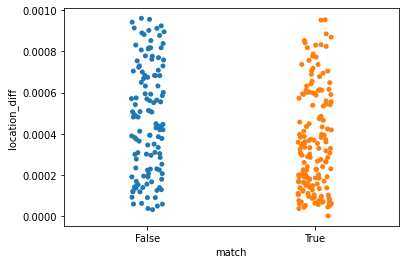

In [ ]:
sns.stripplot(x="match", y="location_diff", data=pairs.loc[(pairs.country_1=='NZ') & (pairs.location_diff<0.001)])
plt.show()

In [ ]:
print('There are',len(pairs.loc[(pairs.location_diff==0) & (pairs.match==False)]),'pairs with location_diff=0 but different POIs, out of all',len(pairs),'pairs.')

There are 574 pairs with location_diff=0 but different POIs, out of all 578907 pairs.


In [ ]:
pairs.loc[(pairs.country_1=='NZ') & (pairs.location_diff>5)].values

array([['E_e4da3f6a7ad158', 'Aoraki Mount Cook', -43.73289364636436,
        170.09544602116455, 'Mt Cook National Park',
        'Mount Cook Village', 'Canterbury', nan, 'NZ',
        'http://www.doc.govt.nz', nan, 'Mountains', 'E_faaaf010fbdf76',
        'Mt. Cook', -38.13113938012586, 176.24823588915947, nan, nan,
        nan, nan, 'NZ', nan, nan, 'Mountains', True, 6.152789867994926,
        -1.0, 0.4545454545454546]], dtype=object)

### Name

---

We compute the difference for names of each pair in `pairs.csv`. 

In [ ]:
from difflib import SequenceMatcher
import math

In [ ]:
# Reference: https://stackoverflow.com/questions/43916271/python-pandas-sequencematch-columns-for-each-value-and-return-closet-match

def sim_metric(df, col1, col2):
    a = df[col1]
    b = df[col2]
    
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        a = a.lower().replace(" ", "").replace("'", "")
        b = b.lower().replace(" ", "").replace("'", "")
    #if a in b or b in a: 
    #    return 0
    return 1-SequenceMatcher(None, a, b).ratio()


In [ ]:
pairs['name_diff'] = pairs.apply(sim_metric,
                          args=('name_1', 'name_2'),
                          axis=1)

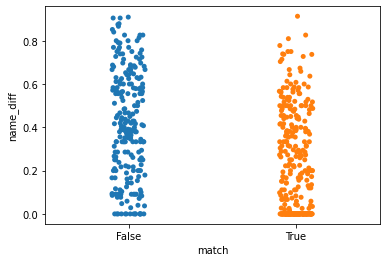

In [ ]:
sns.stripplot(x="match", y="name_diff", data=pairs.loc[pairs.country_1=='NZ'])
plt.show()

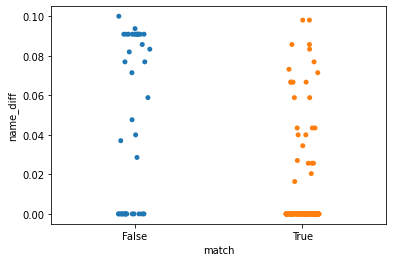

In [ ]:
sns.stripplot(x="match", y="name_diff", data=pairs.loc[(pairs.country_1=='NZ') & (pairs.name_diff<0.1)])
plt.show()

In [ ]:
pairs.loc[(pairs.location_diff<0.01)&(pairs.name_diff==0)&(pairs.match==False)][['name_1','name_2']]

,name_1,name_2
1,Turkcell,Turkcell
4,Coffee Cat,Coffeecat
37,Kipa Extra,Kipa Extra
94,Рубль бум,Рубль Бум
151,LiHO,LiHO
...,...,...
578607,Cosi,Cosi
578614,ПЭК,ПЭК
578773,The Coffee Bean & Tea Leaf,The Coffee Bean & Tea Leaf
578894,7-Eleven,7-Eleven


In [ ]:
pairs.loc[pairs.name_1=='Turkcell']

,id_1,name_1,latitude_1,longitude_1,address_1,city_1,state_1,zip_1,country_1,url_1,...,state_2,zip_2,country_2,url_2,phone_2,categories_2,match,location_diff,address_diff,name_diff
1,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,...,NaN,67500,TR,NaN,NaN,Electronics Stores,False,0.006490,0.793103,0.000000
43268,E_13399d0868886d,Turkcell,38.455899,27.118820,NaN,NaN,NaN,NaN,TR,NaN,...,Karşıyaka,NaN,TR,NaN,NaN,Distribution Centers,False,0.003390,-1.000000,0.000000
263706,E_744ad2ebec744d,Turkcell,40.983061,29.132542,Küçükbakkalköy Mah. Dudullu Cad. No:23-25,Ataşehir,Atasehir,34750,TR,NaN,...,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,True,0.001002,-1.000000,0.407407
305574,E_86e160273c83bb,Turkcell,38.723480,35.496717,Hunat Mah. Sivas Cad. No:24/1,Melikgazi,Kayseri,38140,TR,http://www.turkcell.com.tr,...,NaN,NaN,TR,NaN,NaN,Electronics Stores,True,0.000082,-1.000000,0.238095
385307,E_aa2cc5e2aa773e,Turkcell,36.863923,30.728908,NaN,NaN,NaN,NaN,TR,NaN,...,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,True,0.000477,-1.000000,0.000000


### Address

In [ ]:
pairs['address_diff'] = pairs.apply(sim_metric,
                          args=('address_1', 'address_2'),
                          axis=1)

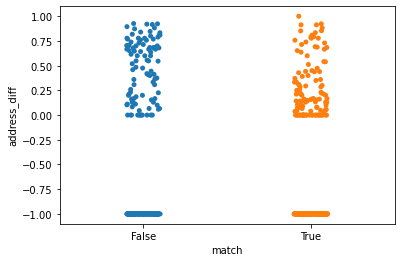

In [ ]:
sns.stripplot(x="match", y="address_diff", data=pairs.loc[pairs.country_1=='NZ'])
plt.show()

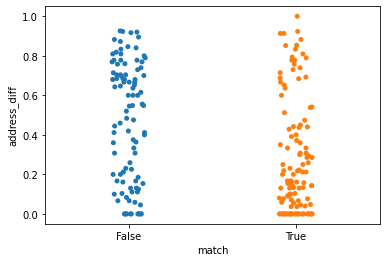

In [ ]:
sns.stripplot(x="match", y="address_diff", data=pairs.loc[(pairs.country_1=='NZ')&(pairs.address_diff>=0)])
plt.show()

In [ ]:
pairs.loc[(pairs.location_diff<0.01)&(pairs.name_diff<0.1)&(pairs.address_diff==0)&(pairs.match==False)&(pairs.country_1=='US')][['name_1','name_2','address_1','address_2']]

,name_1,name_2,address_1,address_2
532,Parkview High School Building H,Parkview High School Building C,"998 Cole Dr, Lilburn, GA 30047","998 Cole Dr, Lilburn, GA 30047"
2526,Sprague Lake Rest Area (Westbound),Sprague Lake Rest Area (Eastbound),Interstate 90,Interstate 90
5315,Section 304,Section 305,KeyBank Center,KeyBank Center
5316,Section 304,Section 308,KeyBank Center,KeyBank Center
6259,Facebook 1050 Building 2,Facebook 1050 Building 1,1050 Page Mill Rd,1050 Page Mill Rd
...,...,...,...,...
571522,Conference Room HS 2007,Conference Room HS 2038,Health Information and Translational Science (HS),Health Information and Translational Science (HS)
572791,Mann Center for the Performing Arts,Mann Center for the Performing Arts D Gate,5201 Parkside Ave,5201 Parkside Ave
575350,Pozez Education Center Centennial D,Pozez Education Center Centennial A,1505 SW 8th Ave,1505 SW 8th Ave
576064,UCF Business Administration II (BA2),UCF Business Administration I (BA1),4000 Central Florida Blvd,4000 Central Florida Blvd


In [ ]:
pairs.match.value_counts()

True     398786
False    180121
Name: match, dtype: int64

In [ ]:
pairs.loc[pairs.location_diff<1].match.value_counts()

True     394720
False    179720
Name: match, dtype: int64

### City

In [ ]:
pairs['city_diff'] = pairs.apply(sim_metric,
                          args=('city_1', 'city_2'),
                          axis=1)

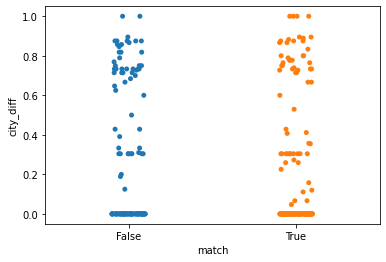

In [ ]:
sns.stripplot(x="match", y="city_diff", data=pairs.loc[(pairs.country_1=='NZ')&(pairs.city_diff>=0)])
plt.show()

In [ ]:
pairs.loc[(pairs.location_diff<0.01)&(pairs.name_diff<0.1)&(pairs.address_diff==0)&(pairs.city_diff==0)&(pairs.match==False)&(pairs.country_1=='US')][['name_1','name_2','address_1','address_2']]

,name_1,name_2,address_1,address_2
532,Parkview High School Building H,Parkview High School Building C,"998 Cole Dr, Lilburn, GA 30047","998 Cole Dr, Lilburn, GA 30047"
2526,Sprague Lake Rest Area (Westbound),Sprague Lake Rest Area (Eastbound),Interstate 90,Interstate 90
5315,Section 304,Section 305,KeyBank Center,KeyBank Center
5316,Section 304,Section 308,KeyBank Center,KeyBank Center
6259,Facebook 1050 Building 2,Facebook 1050 Building 1,1050 Page Mill Rd,1050 Page Mill Rd
...,...,...,...,...
571522,Conference Room HS 2007,Conference Room HS 2038,Health Information and Translational Science (HS),Health Information and Translational Science (HS)
572791,Mann Center for the Performing Arts,Mann Center for the Performing Arts D Gate,5201 Parkside Ave,5201 Parkside Ave
575350,Pozez Education Center Centennial D,Pozez Education Center Centennial A,1505 SW 8th Ave,1505 SW 8th Ave
576064,UCF Business Administration II (BA2),UCF Business Administration I (BA1),4000 Central Florida Blvd,4000 Central Florida Blvd


### State

### Zip


---

Zip codes are stored as strings in the orginal data.

In [ ]:
pairs['zip_diff'] = pairs.apply(sim_metric,
                          args=('zip_1', 'zip_2'),
                          axis=1)

### Histogram

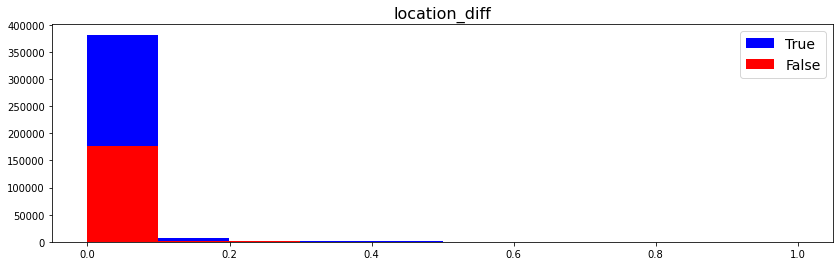

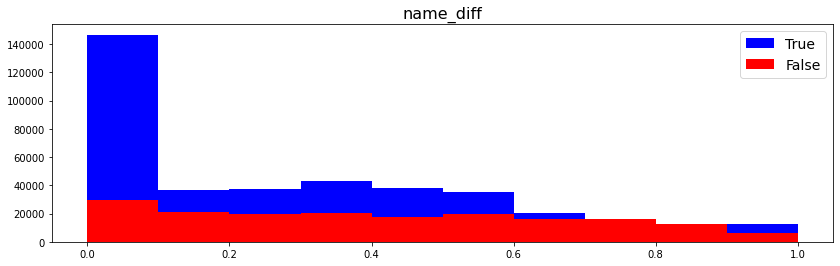

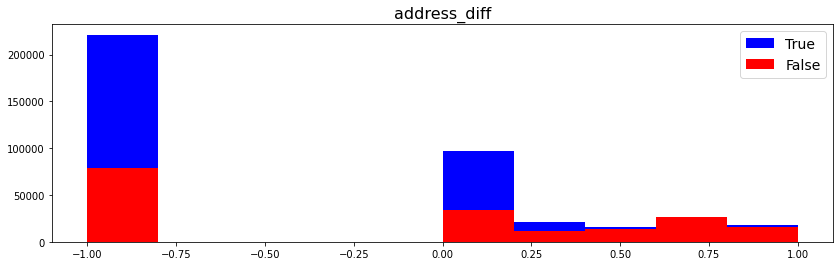

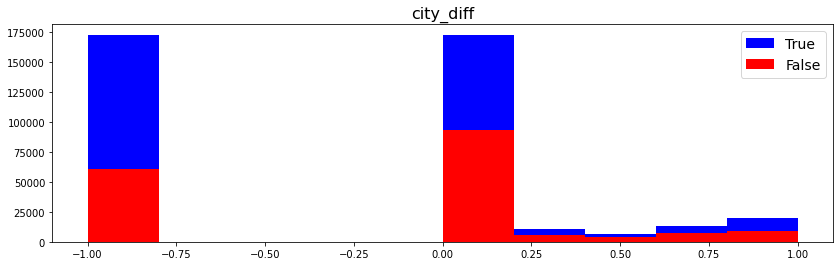

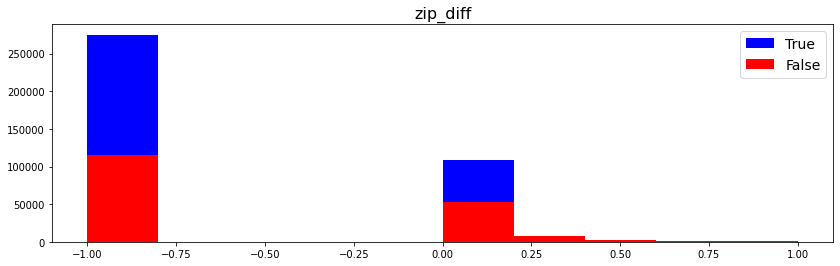

In [ ]:
## histograms
for column in ['location_diff','name_diff','address_diff','city_diff','zip_diff']:
    plt.figure(figsize=(14,4))
    plt.hist(pairs.loc[(pairs.match==True)&(pairs.location_diff<1), column], color='b', label="True")
    plt.hist(pairs.loc[(pairs.match==False)&(pairs.location_diff<1), column], color='r', label="False")
    plt.legend(fontsize=14)
    plt.title(column,fontsize=16)
    plt.show()

In [ ]:
pairs.loc[(pairs.zip_diff>=0)& (pairs.address_diff>=0) &(pairs.city_diff>=0)].describe()

,latitude_1,longitude_1,latitude_2,longitude_2,location_diff,address_diff,name_diff,city_diff,zip_diff
count,146296.000000,146296.000000,146296.000000,146296.000000,146296.000000,146296.000000,146296.000000,146296.000000,146296.000000
mean,32.508102,-19.754487,32.507059,-19.749836,0.112072,0.259217,0.272320,0.101759,0.064743
std,19.752757,86.559842,19.752648,86.555004,2.783567,0.311993,0.293101,0.259665,0.158218
min,-54.799297,-165.408817,-54.794648,-164.436100,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.402049,-87.476469,30.402455,-87.473680,0.000270,0.000000,0.000000,0.000000,0.000000
50%,37.919794,-71.079899,37.912299,-71.082107,0.000926,0.103448,0.187500,0.000000,0.000000
75%,42.879486,29.328887,42.877831,29.315263,0.004111,0.538462,0.483871,0.000000,0.000000
max,71.169826,176.919425,71.170043,176.929571,244.365184,1.000000,1.000000,1.000000,1.000000


# Plotting latitude and longitude


---



In [ ]:
latitude_all = train.latitude.values
longitude_all = train.longitude.values

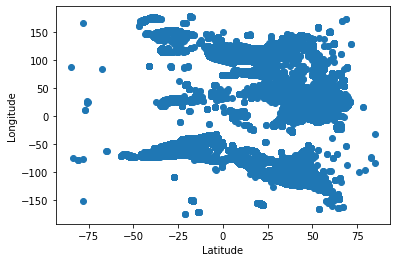

In [ ]:
plt.scatter(latitude_all, longitude_all)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [ ]:
pairs.iloc[4]

id_1                              E_0000c362229d93
name_1                                  Coffee Cat
latitude_1                                7.082218
longitude_1                             125.610244
address_1                            F. Torres St.
city_1                                  Davao City
state_1                               Davao Region
zip_1                                         8000
country_1                                       PH
url_1                                          NaN
phone_1                                        NaN
categories_1                   Cafés, Coffee Shops
id_2                              E_d52c3c4d53831c
name_2                                   Coffeecat
latitude_2                                7.076016
longitude_2                             125.611457
address_2                     E. Jacinto Extension
city_2                                  Davao City
state_2                               Davao Region
zip_2                          

# Submission

---


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Summer 2022/foursquare-location-matching/sample_submission.csv')

In [ ]:
submission

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98


In [ ]:
set(test.id).intersection(set(train.id))

{'E_001b6bad66eb98', 'E_0283d9f61e569d'}

In [ ]:
df = train.loc[train.id==test.id[3]]
df.append(train.loc[train.id==test.id[4]])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
434,E_001b6bad66eb98,Foreword Communicatons,1.302216,103.861456,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_540b73568b0d3c
11033,E_0283d9f61e569d,風雲児 (Fu-unji),35.687101,139.696684,代々木2-14-3,渋谷区,東京都,151-0053,JP,http://www.fu-unji.com,0364138480,Ramen Restaurants,P_fe5531aa3acd9d


In [ ]:
test.columns

Index(['id', 'name', 'latitude', 'longitude', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories'],
      dtype='object')

In [ ]:
test.country

0    MY
1    US
2    RU
3    ID
4    ID
Name: country, dtype: object